In [9]:
# Imports
%load_ext autoreload
%autoreload 2

# ignore warnings for readability
import warnings
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import synthesizer
from synthesizer.parametric import Galaxy
from synthesizer.emission_models.attenuation import Inoue14
from synthesizer.emission_models import PacmanEmission, TotalEmission, EmissionModel, IntrinsicEmission, StellarEmissionModel, STELLAR_MODELS, IncidentEmission
from synthesizer.emission_models.attenuation import PowerLaw
from synthesizer.emissions import plot_spectra
from synthesizer.emission_models.dust.emission import Greybody
from synthesizer.grid import Grid
from synthesizer.parametric import SFH, Stars, ZDist
from synthesizer import check_openmp
from synthesizer.instruments import Instrument, FilterCollection

from typing import Dict, Any, List, Tuple, Union, Optional, Type
from abc import ABC, abstractmethod
import copy
from scipy.stats import uniform, loguniform
from astropy.io import ascii
from unyt import unyt_array, unyt_quantity, erg, cm, s, Angstrom, um, Hz, m, nJy, K, Msun, Myr, yr, Unit, kg
from unyt.equivalencies import SpectralEquivalence
from astropy.cosmology import Planck18, Cosmology, z_at_value
import astropy.units as u
from matplotlib.ticker import ScalarFormatter, FuncFormatter
from tqdm import tqdm
from ltu_ili_testing import (generate_emission_models, generate_sfh_basis, 
                            generate_metallicity_distribution, 
                            generate_constant_R, GalaxyBasis, CombinedBasis,
                            calculate_muv, draw_from_hypercube)
# Filters
# ---------------------------------------------------------------
# all medium and wide band filters for JWST NIRCam
filter_codes = [
    "JWST/NIRCam.F070W", "JWST/NIRCam.F090W", "JWST/NIRCam.F115W", "JWST/NIRCam.F140M",
    "JWST/NIRCam.F150W", "JWST/NIRCam.F162M", "JWST/NIRCam.F182M", "JWST/NIRCam.F200W",
    "JWST/NIRCam.F210M", "JWST/NIRCam.F250M", "JWST/NIRCam.F277W", "JWST/NIRCam.F300M",
    "JWST/NIRCam.F335M", "JWST/NIRCam.F356W", "JWST/NIRCam.F360M", "JWST/NIRCam.F410M",
    "JWST/NIRCam.F430M", "JWST/NIRCam.F444W", "JWST/NIRCam.F460M", "JWST/NIRCam.F480M",
]

# Consistent wavelength grid for both SPS grids and filters
new_wav = generate_constant_R(R=300)

filterset = FilterCollection(filter_codes, new_lam=new_wav)
instrument = Instrument('JWST', filters=filterset)



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
# params
Nmodels = 1e3
redshift = (5, 12)
masses = (5, 10)
weights = (0, 1)
max_redshift = 20 # gives maximum age of SFH at a given redshift
cosmo = Planck18 # cosmology to use for age calculations

# ---------------------------------------------------------------
# Pop II

tau_v = (0.0, 2.0)
log_zmet = (-3, 0.3)

# SFH
sfh_type = SFH.LogNormal
tau = (0.05, 2.5)
peak_age = (-1, 1) # normalized to maximum age of the universe at that redshift
sfh_param_units = [None, None]

# ---------------------------------------------------------------
# Pop III

min_age_popIII = (0.00, 29) # Myr
max_age_popIII = (0.01, 30) # Myr

# ---------------------------------------------------------------

# Generate the grid

full_params = {
    'redshift': redshift,
    'masses': masses,
    'weights': weights,
    'tau_v': tau_v,
    'log_zmet': log_zmet,
    'tau': tau,
    'peak_age': peak_age,
    'min_age_popIII': min_age_popIII,
    'max_age_popIII': max_age_popIII
}

# Generate the grid

param_grid = draw_from_hypercube(Nmodels, full_params, rng=42)

# Unpack the parameters

all_param_dict = {}
for i, key in enumerate(full_params.keys()):
    all_param_dict[key] = param_grid[:, i]


grid = Grid('bpass-2.2.1-bin_chabrier03-0.1,300.0_cloudy-c23.01-sps.hdf5',
            grid_dir='/home/tharvey/work/synthesizer_grids/',
            new_lam=new_wav)

# Metallicity 
Z_dists = [ZDist.DeltaConstant(log10metallicity=log_z) for log_z in all_param_dict['log_zmet']]

redshifts = np.array(all_param_dict['redshift'])

# Pop II SFH
sfh_param_arrays = np.vstack((all_param_dict['tau'], all_param_dict['peak_age'])).T
sfh_models, _ = generate_sfh_basis(
    sfh_type=sfh_type,
    sfh_param_names=['tau', 'peak_age_norm'],
    sfh_param_arrays=sfh_param_arrays,
    redshifts=redshifts,
    max_redshift=max_redshift,
    cosmo=cosmo,
    sfh_param_units=sfh_param_units,
    iterate_redshifts=False,
    calculate_min_age=False,
)

# Emission parameters
emission_model = TotalEmission(
    grid=grid,
    fesc=0.1,
    fesc_ly_alpha=0.1,
    dust_curve=PowerLaw(slope=-0.7),
    dust_emission_model=None,
)

# List of other varying or fixed parameters. Either a distribution to pull from or a list.
# Can be any parameter which can be property of emitter or galaxy and processed by the emission model.
galaxy_params={
    'tau_v': all_param_dict['tau_v'],
}

popII_basis = GalaxyBasis(
    model_name='Pop II',
    redshifts=redshifts,
    grid=grid,
    emission_model=emission_model,
    sfhs=sfh_models,
    cosmo=cosmo,
    instrument=instrument,
    metal_dists=Z_dists,
    galaxy_params=galaxy_params,
    redshift_dependent_sfh=True,
    params_to_ignore=['max_age'], # This is dependent on the redshift and should not be included in the basis
    build_grid=False,
)


# Second Population Model
# ---------------------------------------------------------------

popIII_grid = Grid('yggdrasil-1.3.3-PopIII_salpeter-10,1,500',
                    grid_dir='/home/tharvey/work/synthesizer_grids/',
                    read_lines=False, new_lam=new_wav)


# Pop III parameters

# SFH
sfh_array = np.vstack((all_param_dict['min_age_popIII'], all_param_dict['max_age_popIII'])).T

sfh_param_units = [Myr, Myr]
popIII_sfhs, _ = generate_sfh_basis(
    sfh_type=SFH.Constant,
    sfh_param_names=['min_age', 'max_age'],
    sfh_param_arrays=sfh_array,
    redshifts=redshifts,
    max_redshift=max_redshift,
    cosmo=cosmo,
    sfh_param_units=sfh_param_units,
    calculate_min_age=False,
    iterate_redshifts=False,
)

popIII_metal_dists = ZDist.DeltaConstant(metallicity=0)

if 'incident' not in grid.available_spectra:
    # Need a custom emission model for the Pop III grid if loading the nebular spectra. 
    popIII_emission_model = EmissionModel(
        label = 'Pop III',
        extract=popIII_grid.available_spectra[0],
        grid=popIII_grid,
        emitter='stellar'
    )
else:
    popIII_emission_model = IncidentEmission(
        grid=popIII_grid,
    )

popIII_basis = GalaxyBasis(
    model_name='Pop III',
    redshifts=redshifts,
    grid=popIII_grid,
    emission_model=popIII_emission_model,
    sfhs=popIII_sfhs,
    cosmo=cosmo,
    instrument=instrument,
    metal_dists=popIII_metal_dists,
    redshift_dependent_sfh=True,
    build_grid=False,
)

weights = np.array([np.array([i, 1-i]) for i in all_param_dict['weights']])



Creating SFHs: 1000it [00:00, 38526.16it/s]


Generating grid directly from provided parameter samples.


Creating SFHs: 1000it [00:00, 48449.30it/s]

Generating grid directly from provided parameter samples.


In [4]:
grid = Grid('bpass-2.2.1-bin_chabrier03-0.1,300.0_cloudy-c23.01-sps.hdf5',
            grid_dir='/home/tharvey/work/synthesizer_grids/',
            new_lam=new_wav)

grid.metallicity

unyt_array([1.0e-05, 1.0e-04, 1.0e-03, 2.0e-03, 3.0e-03, 4.0e-03, 6.0e-03,
       8.0e-03, 1.0e-02, 1.4e-02, 2.0e-02, 3.0e-02, 4.0e-02], 'dimensionless')

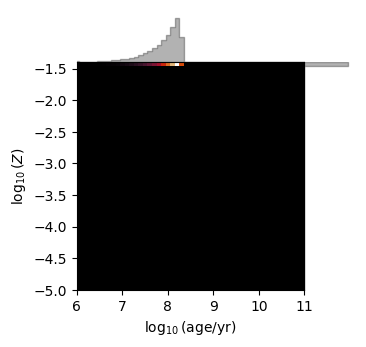

(<Figure size 350x350 with 3 Axes>,
 <Axes: xlabel='$\\log_{10}(\\mathrm{age}/\\mathrm{yr})$', ylabel='$\\log_{10}(Z)$'>)

In [28]:
zh = ZDist.DeltaConstant(metallicity=0.04)

sfh = SFH.Constant(
    min_age=0 * Myr,
    max_age=200*Myr,
)


stars = Stars(
    redshift=10,
    metal_dist=zh,
    sf_hist=sfh,
    initial_mass=1e8*Msun,
    log10ages=grid.log10ages,
    metallicities=grid.metallicities,
)

stars.plot_sfzh()



In [38]:
help(filterset)

Help on FilterCollection in module synthesizer.instruments.filters object:

class FilterCollection(builtins.object)
 |  FilterCollection(filter_codes=None, tophat_dict=None, generic_dict=None, filters=None, path=None, new_lam=None, fill_gaps=True, verbose=False)
 |  
 |  A container for multiple Filter objects.
 |  
 |  Holds a collection of filters (`Filter` objects) and enables various
 |  quality of life operations such as plotting, adding, looping, len,
 |  and comparisons as if the collection was a simple list.
 |  
 |  Filters can be derived from the
 |  `SVO database <http://svo2.cab.inta-csic.es/svo/theory/fps3/>`__
 |  , specific top hat filter
 |  properties or generic filter transmission curves and a wavelength array.
 |  
 |  All filters in the `FilterCollection` are defined in terms of the
 |  same wavelength array.
 |  
 |  In addition to creating `Filter`s from user defined arguments, a HDF5
 |  file of a `FilterCollection` can be created and later loaded at
 |  instanti

In [9]:
# --------------------------------------------------------------
# Combine the two population models

combined_basis = CombinedBasis(
    bases=[popII_basis, popIII_basis],
    total_stellar_masses=unyt_array(10**all_param_dict['masses'], units=Msun),
    base_emission_model_keys=['total', popIII_emission_model.label],
    combination_weights=weights,
    redshifts=redshifts,
    out_name='combined_basis_lhc',
    out_dir='/home/tharvey/work/output/',
    draw_parameter_combinations=False, # Since we have already drawn the parameters, we don't need to combine them again.
)

# Passing in extra analysis function to pipeline to calculate mUV. Any funciton could be passed in. 
combined_basis.process_bases(overwrite=False, mUV=(calculate_muv, cosmo))

combined_basis.create_grid(overwrite=True)


File /home/tharvey/work/output//combined_basis_lhc_Pop II.hdf5 already exists. Skipping.
File /home/tharvey/work/output//combined_basis_lhc_Pop III.hdf5 already exists. Skipping.
Emission model key for base Pop II: total
Emission model key for base Pop III: incident


Combined outputs shape: (20, 1000)
Combined parameters shape: (9, 1000)
Combined supplementary parameters shape: (1, 1000)
Combined parameters: [[ 5.05658293  7.24431658  5.49878454 ...  5.72211266  6.79716825
   9.48970318]
 [ 5.25044537  7.82710409  8.46246052 ...  8.42976189  7.85969591
   6.96333504]
 [ 0.7071234   0.56382453  0.13383886 ...  0.46001473  0.71165949
   0.58311015]
 ...
 [ 0.17144963 -1.21776211 -2.29977274 ... -1.80126393 -1.47736537
  -2.43424249]
 [15.11619091  0.35005975  3.55023313 ... 26.54408836 13.0123291
  14.45955563]
 [19.94883919  6.66734266 29.18622208 ... 15.68573666 22.22473526
  17.69644928]]
Filter codes: ['NIRCam.F070W', 'NIRCam.F090W', 'NIRCam.F115W', 'NIRCam.F140M', 'NIRCam.F150W', 'NIRCam.F162M', 'NIRCam.F182M', 'NIRCam.F200W', 'NIRCam.F210M', 'NIRCam.F250M', 'NIRCam.F277W', 'NIRCam.F300M', 'NIRCam.F335M', 'NIRCam.F356W', 'NIRCam.F360M', 'NIRCam.F410M', 'NIRCam.F430M', 'NIRCam.F444W', 'NIRCam.F460M', 'NIRCam.F480M']
File /home/tharvey/work/output

In [7]:
from joblib import Parallel, delayed

def create_test_galaxy():
    return Galaxy(
        stars=Stars(
            redshift=10,
            metal_dist=ZDist.DeltaConstant(metallicity=0),
            sf_hist=SFH.Constant(
                min_age=0 * Myr,
                max_age=200*Myr,
            ),
            initial_mass=1e8*Msun,
            log10ages=grid.log10ages,
            metallicities=grid.metallicities,
        )
    )

%timeit create_test_galaxy()

2.99 ms ± 14.6 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


(0.0, 800000000.0)

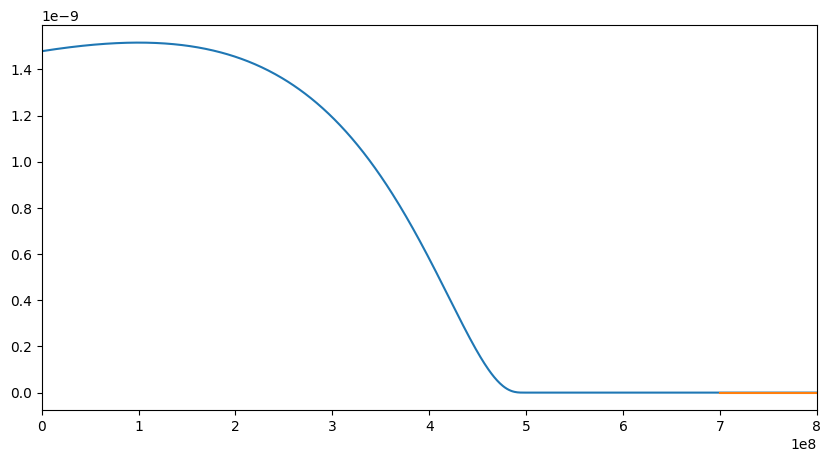

In [22]:
sfh1 = SFH.LogNormal(
    peak_age=100*Myr,
    tau=1,
    max_age=500*Myr,
)

sfh2 = SFH.LogNormal(
    peak_age=800*Myr,
    tau=0.5,
    max_age=700*Myr,
)

fig, ax = plt.subplots(1, 1, figsize=(10, 5))

t, s = sfh1.calculate_sfh()
ax.plot(t, s, label='SFH 1')

t, s = sfh2.calculate_sfh()
ax.plot(t, s, label='SFH 2')

ax.set_xlim(0, 800*1e6)
